# Training Section

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters for RandomForest: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Optimal number of features for Random Forest: 9
Selected features for Random Forest: ['num__PARENT_OUT_ZONE_MIN_HYPOT' 'num__PARENT_OUT_ZONE_MIN_MAP_DIST'
 'num__PARENT_1050_MEDIAN_WELL_AGE' 'num__PARENT_1050_WELL_COUNT'
 'num__PARENT_3000_AVG_HYPOT_DIST' 'num__PARENT_3000_AVG_MAP_DIST'
 'num__PARENT_3000_WELL_COUNT' 'num__CODEV_IN_ZONE_MIN_MAP_DIST'
 'num__CODEV_3000_AVG_HYPOT_DIST']
Saved the best model with MAPE: 13.08475218469812%


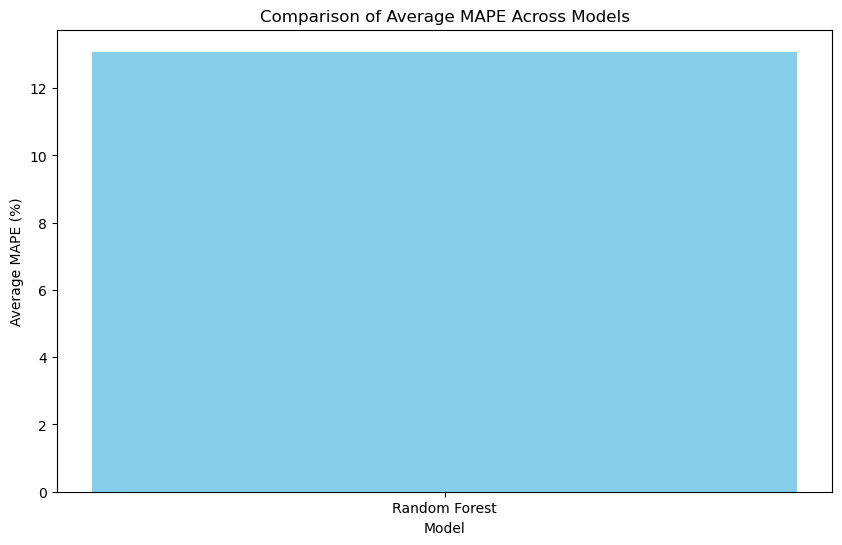

Selected features for Random Forest: ['num__PARENT_OUT_ZONE_MIN_HYPOT' 'num__PARENT_OUT_ZONE_MIN_MAP_DIST'
 'num__PARENT_1050_MEDIAN_WELL_AGE' 'num__PARENT_1050_WELL_COUNT'
 'num__PARENT_3000_AVG_HYPOT_DIST' 'num__PARENT_3000_AVG_MAP_DIST'
 'num__PARENT_3000_WELL_COUNT' 'num__CODEV_IN_ZONE_MIN_MAP_DIST'
 'num__CODEV_3000_AVG_HYPOT_DIST']



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import json
import joblib


# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    ape = 100 * np.abs((y_true - y_pred) / y_true)
    return np.mean(ape)

# Load your data
data_dir = 'Train_HackathonData2024.csv'
data = pd.read_csv(data_dir)

# Define the target and feature variables
target = 'PARENT_IN_ZONE_MIN_HYPOT'
features = ['Avg Pump Difference', 'Area', 'Lateral Length', 'Fluid System', 'TVD', 
            'Development Strategy', 'DELAYED', 'BOUND_CODE', 'CODEV_POSITION', 
            'CODEV_FORMATION_POSITION', 'PARENT_CODEV_1050_WELL_COUNT', 'PARENT_OUT_ZONE_MIN_HYPOT', 
            'PARENT_OUT_ZONE_MIN_MAP_DIST', 
            'PARENT_1050_AVG_WELL_AGE', 'PARENT_1050_MEDIAN_WELL_AGE', 'PARENT_1050_WELL_COUNT', 
            'PARENT_3000_AVG_HYPOT_DIST', 'PARENT_3000_AVG_MAP_DIST', 'PARENT_3000_AVG_TVD_DIST', 
            'PARENT_3000_AVG_WELL_AGE', 'PARENT_3000_MEDIAN_WELL_AGE', 'PARENT_3000_WELL_COUNT', 
            'CODEV_IN_ZONE_MIN_HYPOT', 'CODEV_OUT_ZONE_MIN_HYPOT', 'CODEV_IN_ZONE_MIN_MAP_DIST', 
            'CODEV_1050_WELL_COUNT', 'CODEV_3000_AVG_HYPOT_DIST', 'CODEV_3000_AVG_MAP_DIST', 
            'CODEV_3000_AVG_TVD_DIST', 'CODEV_3000_AVG_WELL_AGE', 'CODEV_3000_MEDIAN_WELL_AGE', 
            'CODEV_3000_WELL_COUNT', 'Pressure Gradient (psi/ft) new', 'Soak Time', 
            'Avg Open Pressure', 'Avg Close Pressure']
categorical_features = ['Area', 'Fluid System', 'Development Strategy', 'DELAYED', 'BOUND_CODE', 'CODEV_POSITION', 'CODEV_FORMATION_POSITION']
numerical_features = [f for f in features if f not in categorical_features]

# Keep only the relevant features and target
data = data[[target] + features]
data = data.dropna(subset=[target])

# Preprocessing
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define target and features
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a new pipeline including both preprocessing and the model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid for RandomForestRegressor
rf_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Instantiate the grid search model
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=10, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

# Best parameters
rf_best_params = rf_grid_search.best_params_
print(f"Best parameters for RandomForest: {rf_best_params}")

# # Hyperparameter tuning for DecisionTreeRegressor
# # Uncomment the below code for hyperparameter tuning

# # Define a new pipeline for DecisionTreeRegressor including preprocessing and the model
# dt_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', DecisionTreeRegressor(random_state=42))
# ])

# # Hyperparameter grid for DecisionTreeRegressor
# dt_param_grid = {
#     'model__max_depth': [None, 10, 20, 30],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4]
# }

# # Instantiate the grid search model for DecisionTreeRegressor
# dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=10, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# # Fit the grid search to the data for DecisionTreeRegressor
# dt_grid_search.fit(X_train, y_train)

# # Best parameters for DecisionTreeRegressor
# dt_best_params = dt_grid_search.best_params_
# print(f"Best parameters for DecisionTree: {dt_best_params}")

# # Remove 'model__' prefix from the parameter keys
# rf_best_params_cleaned = {k.replace('model__', ''): v for k, v in rf_best_params.items()}
# dt_best_params_cleaned = {k.replace('model__', ''): v for k, v in dt_best_params.items()}

# # Combine the parameters into one dictionary
# hyperparameters = {
#     'RandomForest': rf_best_params_cleaned,
#     'DecisionTree': dt_best_params_cleaned
# }

# # Save to a JSON file
# with open('model_hyperparameters.json', 'w') as file:
#     json.dump(hyperparameters, file, indent=4)

# Load Existing Hyperparameters from a JSON file
with open('model_hyperparameters.json', 'r') as file:
    loaded_hyperparameters = json.load(file)

# Access the parameters for each model
rf_best_params_cleaned = loaded_hyperparameters['RandomForest']
    
# RFECV and Model Evaluation

# List of models to train
models = [
    ('Random Forest', RandomForestRegressor(**rf_best_params_cleaned, random_state=42))
]

# Dictionary to store the average MAPE for each model
average_mape_scores = {}
selected_features = {}

# K-Fold for RFECV
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize code to keep track of the best MAPE
best_mape = float('inf')
best_model = None
best_model_name = ""

# Iterate over models
for model_name, model in models:
    # Create the RFE object and compute a cross-validated score
    rfecv = RFECV(estimator=model, step=1, cv=kf, scoring='neg_mean_absolute_error', min_features_to_select = 5)

    # Fit RFECV within the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('rfecv', rfecv)])
    pipeline.fit(X_train, y_train)

    # Access the RFECV object from the fitted pipeline
    rfecv_fitted = pipeline.named_steps['rfecv']

    # Transform the feature names through the pipeline to match the transformed data
    transformed_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)

    # Get the mask of the selected features from the fitted RFECV object
    selected_features_mask = rfecv_fitted.support_

    # Summarize the selection of the attributes
    selected_features[model_name] = transformed_feature_names[selected_features_mask]
    print(f"Optimal number of features for {model_name}: {len(selected_features[model_name])}")
    print(f"Selected features for {model_name}: {selected_features[model_name]}")

    # Transform test set and predict
    X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
    predictions = rfecv_fitted.predict(X_test_transformed)

    # Calculate and store MAPE
    mape = calculate_mape(y_test, predictions)
    average_mape_scores[model_name] = mape

    # Check if this model has the best MAPE so far
    if mape < best_mape:
        best_mape = mape
        best_model = rfecv_fitted
        best_model_name = model_name

# Save the best model to a file
if best_model:
    model_filename = f"parent_in_zone_min_hypot_model.joblib"
    joblib.dump(best_model, model_filename)
    print(f"Saved the best model with MAPE: {best_mape}%")
else:
    print("No model was saved.")
        
# Plotting the average MAPE for each model
plt.figure(figsize=(10, 6))
plt.bar(average_mape_scores.keys(), average_mape_scores.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Average MAPE (%)')
plt.title('Comparison of Average MAPE Across Models')
plt.show()

# Print selected features
for model_name, features in selected_features.items():
    print(f"Selected features for {model_name}: {features}\n")

# Prediction Section

In [ ]:
# Load the original dataset again for imputation
data_for_imputation = pd.read_csv('Train_HackathonData2024.csv')

# Preprocess the entire dataset for imputation
X_for_imputation = data_for_imputation[features]
X_for_imputation_transformed = preprocessing_pipeline.fit_transform(X_for_imputation)

# Identify rows where target value is missing
missing_target_mask = data_for_imputation[target].isnull()

# Predict missing values using the best model
# Note: Ensure that the best_model is the RFECV fitted model from the previous steps
imputed_values = best_model.predict(X_for_imputation_transformed[missing_target_mask])

# Impute the missing values in the dataset
data_for_imputation.loc[missing_target_mask, target] = imputed_values

# Save the cleaned dataset
data_for_imputation.to_csv('Cleaned_Train_HackathonData2024.csv', index=False)

print("Missing values for 'PARENT_IN_ZONE_MIN_HYPOT' have been imputed and saved to 'Cleaned_Train_HackathonData2024.csv'")